In [ ]:
#code

In [ ]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
from glob import glob

# Create output directory if not exists
os.makedirs('output', exist_ok=True)

# Image Shape (FF++ has larger images, we resize to 128x128)
img_shape = (3, 128, 128)

In [ ]:
# Define Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 128*128*3)
        self.in1 = nn.BatchNorm1d(128)
        self.in2 = nn.BatchNorm1d(512)
        self.in3 = nn.BatchNorm1d(1024)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.in2(self.fc2(x)), 0.2)
        x = F.leaky_relu(self.in3(self.fc3(x)), 0.2)
        x = torch.tanh(self.fc4(x))
        return x.view(x.shape[0], *img_shape)

In [ ]:
# Define Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(128*128*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
# Custom Dataset for FF++
class FFPPDataset(Dataset):
    def __init__(self, real_path, fake_path, transform=None):
        self.real_images = glob(os.path.join(real_path, "*.png")) + glob(os.path.join(real_path, "*.jpg"))
        self.fake_images = glob(os.path.join(fake_path, "*.png")) + glob(os.path.join(fake_path, "*.jpg"))

        self.transform = transform

    def __len__(self):
        return len(self.real_images) + len(self.fake_images)

    def __getitem__(self, idx):
        if idx < len(self.real_images):
            img_path = self.real_images[idx]
            label = 1  # Real
        else:
            img_path = self.fake_images[idx - len(self.real_images)]
            label = 0  # Fake

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Transformations for FF++ images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Dataset
real_path = "/content/drive/MyDrive/real_and_fake_face/training_real"
fake_path = "/content/drive/MyDrive/real_and_fake_face/training_fake"
import os
from glob import glob

print("Real images:", len(glob(os.path.join(real_path, "*.png")) + glob(os.path.join(real_path, "*.jpg"))))
print("Fake images:", len(glob(os.path.join(fake_path, "*.png")) + glob(os.path.join(fake_path, "*.jpg"))))

dataset = DataLoader(
    FFPPDataset(real_path, fake_path, transform),
    batch_size=32, shuffle=True, num_workers=4, pin_memory=True
)


Real images: 1081
Fake images: 970


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Initialize Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
loss_func = torch.nn.BCELoss().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor


In [ ]:
# Training Loop
for epoch in range(6):
    for i, (imgs, labels) in enumerate(dataset):

        real_imgs = imgs.to(device)
        val = Tensor(imgs.size(0), 1).fill_(1.0).to(device)
        fake = Tensor(imgs.size(0), 1).fill_(0.0).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        gen_input = Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))).to(device)
        gen = generator(gen_input)
        g_loss = loss_func(discriminator(gen), val)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = loss_func(discriminator(real_imgs), val)
        fake_loss = loss_func(discriminator(gen.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        print(f"[Epoch {epoch}/10] [Batch {i}/{len(dataset)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Save Generated Images Every 400 Batches
        if (epoch * len(dataset) + i) % 400 == 0:
            save_image(gen.data[:25], f'output/{epoch}_{i}.png', nrow=5, normalize=True)


[Epoch 0/10] [Batch 0/65] [D loss: 0.6925302147865295] [G loss: 0.7175745964050293]
[Epoch 0/10] [Batch 1/65] [D loss: 0.4430375099182129] [G loss: 0.8173807263374329]
[Epoch 0/10] [Batch 2/65] [D loss: 0.356090247631073] [G loss: 1.0394970178604126]
[Epoch 0/10] [Batch 3/65] [D loss: 0.23263172805309296] [G loss: 1.1897006034851074]
[Epoch 0/10] [Batch 4/65] [D loss: 0.20443493127822876] [G loss: 1.2354921102523804]
[Epoch 0/10] [Batch 5/65] [D loss: 0.14737682044506073] [G loss: 1.5532341003417969]
[Epoch 0/10] [Batch 6/65] [D loss: 0.20636117458343506] [G loss: 1.665557622909546]
[Epoch 0/10] [Batch 7/65] [D loss: 0.772726833820343] [G loss: 0.2715193033218384]
[Epoch 0/10] [Batch 8/65] [D loss: 0.5656347274780273] [G loss: 2.14308500289917]
[Epoch 0/10] [Batch 9/65] [D loss: 0.7808363437652588] [G loss: 0.321128785610199]
[Epoch 0/10] [Batch 10/65] [D loss: 0.3609077036380768] [G loss: 0.8027585744857788]
[Epoch 0/10] [Batch 11/65] [D loss: 0.247038334608078] [G loss: 1.47306668758

In [ ]:
# Save Trained Discriminator Model
torch.save(discriminator.state_dict(), "discriminator_ffpp.pth")
print("Trained Discriminator Model Saved!")

Trained Discriminator Model Saved!


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

# Set the correct image dimensions based on the trained model
IMG_SIZE = 224  # Match training image size
IMG_CHANNELS = 3  # 3 for RGB, 1 for grayscale

# Load trained Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(IMG_CHANNELS * IMG_SIZE * IMG_SIZE, 512)  # MATCHING TRAINING MODEL
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.sigmoid(self.fc4(x))
        return x

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
discriminator = Discriminator()

# Load the state_dict correctly
try:
    discriminator.load_state_dict(torch.load("discriminator_ffpp.pth", map_location=device))
except RuntimeError as e:
    print("Model loading error:", e)

discriminator.to(device)
discriminator.eval()

# Function to classify image
def classify_image(image):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),  # MATCH TRAINED SIZE
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Ensure RGB normalization
    ])

    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = discriminator(image)
        probability = output.item()

    # Classification Result
    result = "REAL ✅" if probability > 0.42 else "FAKE ❌"
    return result, f"Confidence: {probability:.4f}"

# Gradio Interface
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil", sources=["upload"]),
    outputs=[gr.Textbox(label="Classification Result"), gr.Textbox(label="Confidence Score")],
    title="Deepfake Image Detector",
    description="Upload an image to check if it's real or fake based on the trained model.",
    theme="default"
)

# Launch the UI
interface.launch()


FileNotFoundError: [Errno 2] No such file or directory: 'discriminator_ffpp.pth'

Final Accuracy: 0.8000
Final Precision: 0.8333


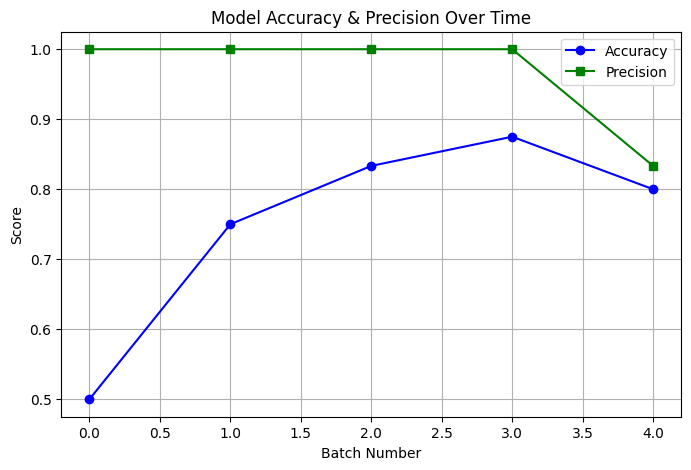

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score

# Example Data (Replace with real classification results)
true_labels = [1, 1, 0, 0, 1, 1, 0, 1, 0, 1]  # Ground truth (1 = Real, 0 = Fake)
predicted_labels = [1, 0, 0, 0, 1, 1, 0, 1, 1, 1]  # Model Predictions

# Compute Accuracy & Precision per batch
batch_size = 2  # Change batch size as needed
accuracy_values = []
precision_values = []

for i in range(0, len(true_labels), batch_size):
    batch_true = true_labels[: i + batch_size]
    batch_pred = predicted_labels[: i + batch_size]

    acc = accuracy_score(batch_true, batch_pred)
    prec = precision_score(batch_true, batch_pred, zero_division=0)

    accuracy_values.append(acc)
    precision_values.append(prec)

# Print final accuracy and precision
final_accuracy = accuracy_values[-1]
final_precision = precision_values[-1]

print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Precision: {final_precision:.4f}")

# Plot Line Graph
plt.figure(figsize=(8, 5))
plt.plot(range(len(accuracy_values)), accuracy_values, marker='o', linestyle='-', color='blue', label="Accuracy")
plt.plot(range(len(precision_values)), precision_values, marker='s', linestyle='-', color='green', label="Precision")

plt.xlabel("Batch Number")
plt.ylabel("Score")
plt.title("Model Accuracy & Precision Over Time")
plt.legend()
plt.grid(True)
plt.show()
